In [1]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import os
import pickle
import lzma
import torch
from metadrive import MetaDriveEnv
from concurrent.futures import ProcessPoolExecutor
from env import State, Observation, Action, next_state, normalize_angle, get_metadrive_state, state_batch_to_tensor, action_batch_to_tensor
from metadrive_model import MetadriveModel, metadrive_model_train_batch
from model_utils import set_lr

In [2]:
def gen_random_state_action() -> tuple[State, Action]:
    """
    Generates a random state with probabilities that are similar to that are found in the waymo dataset
    """
    if np.random.rand() < 0.5:
        # parked 
        vel = np.random.normal(0, 0.01, 2)
        heading = np.random.uniform(-np.pi, np.pi)
        action = np.random.uniform(-1, 1), np.random.normal(0, 0.01)
    else:
        # moving
        vel = np.random.normal(0, 10, 2)
        heading = normalize_angle(np.arctan2(vel[1], vel[0]) + np.random.normal(0, 0.2))
        action = tuple(np.random.uniform(-1, 1, 2))

    return State(heading=heading, velocity=vel), action

def generate_data(n: int) -> list[tuple[State, Action, State]]:
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[tuple[State, Action, State]] = []
    for _ in range(n):
        s0, a = gen_random_state_action()
        s1 = next_state(env, s0, a)
        dataset.append((s0, a, s1))
    env.close()
    return dataset

In [3]:
NUM_SCENARIOS = 500_000
MAX_WORKERS = 16

mm_data: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(NUM_SCENARIOS, MAX_WORKERS)
    
    # Distribute the data evenly among workers
    n_scenarios_per_worker = [batch_size]*MAX_WORKERS
    for i in range(leftover_size):
        n_scenarios_per_worker[i] += 1

    # Generate the data in parallel
    for batch in executor.map(generate_data, n_scenarios_per_worker):
        mm_data.extend(batch)

[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] MetaDrive version: 0.4.1.2
[INFO] Sensors: []
[INFO] MetaDrive version: 0.4.1.2
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Sensors: []
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] Render Mode: none
[INFO] MetaDrive version: 0.4.

In [4]:
# save data
if not os.path.exists("./data/mm_data.pkl.xz"):
    with lzma.open("./data/mm_data.pkl.xz", "wb") as f:
        pickle.dump(mm_data, f)

In [5]:
# load data
if not "mm_data" in locals():
    with lzma.open("./data/mm_data.pkl.xz", "rb") as f:
        mm_data: list[tuple[State, Action, State]] = pickle.load(f)

In [6]:
# 90:10 train-validation split
random.seed(0)
random.shuffle(mm_data)
mm_train_data = mm_data[:int(len(mm_data)*0.9)]
mm_validation_data = mm_data[int(len(mm_data)*0.9):]

In [7]:
print("train data size:", len(mm_train_data))
print("validation data size:", len(mm_validation_data))

train data size: 450000
validation data size: 50000


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
import itertools
# make sure we don't run out of data
mm_train_iter = itertools.cycle(mm_train_data)

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.AdamW(mm.parameters())

mm_step = 0
mm_losses = []

In [10]:
set_lr(mm_optimizer, 1e-4)
METADRIVE_MODEL_TRAIN_EPOCHS = 20000
METADRIVE_MODEL_TRAIN_BATCH_SIZE = 8192

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # take up to n from the data buffer
    s0_batch = []
    a_batch = []
    s1_batch = []
    for _ in range(METADRIVE_MODEL_TRAIN_BATCH_SIZE):
        s0, a, s1 = next(mm_train_iter)
        s0_batch.append(s0)
        a_batch.append(a)
        s1_batch.append(s1)

    # train
    loss = metadrive_model_train_batch(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    if mm_step % 500 == 0:
        # print average loss over the last 500 steps
        loss = np.mean(mm_losses[-500:])
        print(f"Step: {mm_step}, Loss: {loss:.4f}")

Step: 500, Loss: 0.0326
Step: 1000, Loss: 0.0164
Step: 1500, Loss: 0.0131
Step: 2000, Loss: 0.0120
Step: 2500, Loss: 0.0112
Step: 3000, Loss: 0.0103
Step: 3500, Loss: 0.0096
Step: 4000, Loss: 0.0091
Step: 4500, Loss: 0.0084
Step: 5000, Loss: 0.0081
Step: 5500, Loss: 0.0078
Step: 6000, Loss: 0.0074
Step: 6500, Loss: 0.0072
Step: 7000, Loss: 0.0069
Step: 7500, Loss: 0.0067
Step: 8000, Loss: 0.0065
Step: 8500, Loss: 0.0062
Step: 9000, Loss: 0.0061
Step: 9500, Loss: 0.0059
Step: 10000, Loss: 0.0058
Step: 10500, Loss: 0.0056
Step: 11000, Loss: 0.0055
Step: 11500, Loss: 0.0054
Step: 12000, Loss: 0.0053


KeyboardInterrupt: 

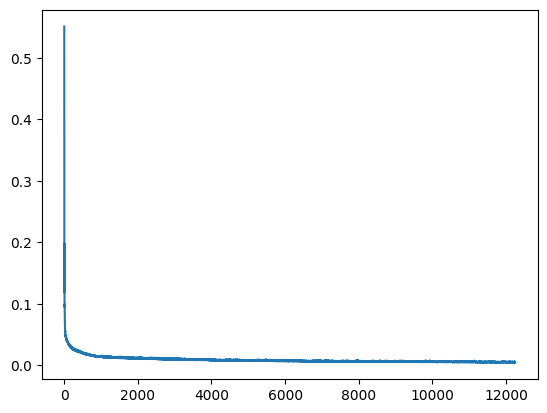

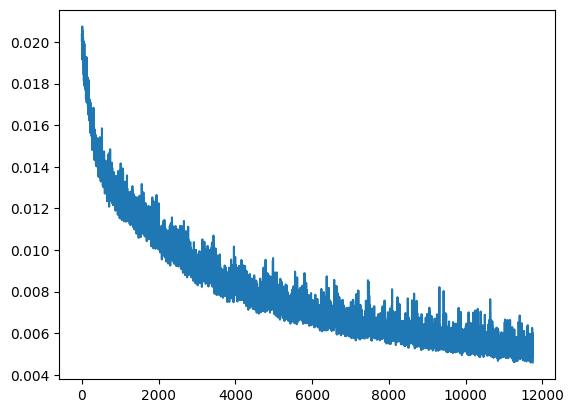

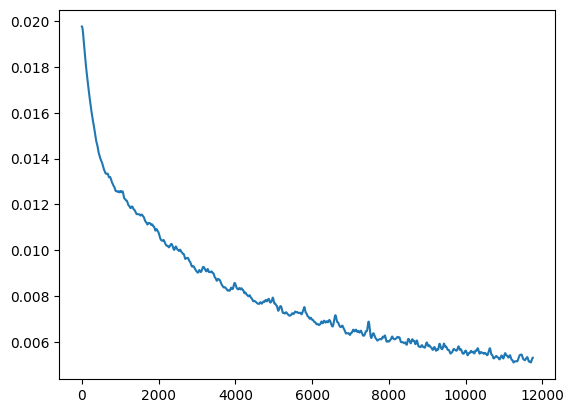

In [11]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


# Plot the losses over training
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

latter_training = mm_losses[500:]
plt.plot(list(range(len(latter_training))), latter_training, label='MM')
plt.show()

# denoise
latter_training_denoised = gaussian_filter1d(latter_training, sigma=20)
plt.plot(list(range(len(latter_training_denoised))), latter_training_denoised, label='MM')
plt.show()

In [ ]:
# load mm
if 'mm' not in locals():
    mm = MetadriveModel().to(device)
    mm.load_state_dict(torch.load('data/mm.pth'))

In [ ]:
# save mm
if not os.path.exists('data/mm.pth'):
    torch.save(mm.state_dict(), 'data/mm.pth')

In [26]:
s0_batch = [s0 for s0, _, _ in mm_train_data]
s1_batch = [s1 for _, _, s1 in mm_train_data]
a_batch = [a for _, a, _ in mm_train_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2] + loss[:, 3]

print("training loss", loss.mean().item())

training loss 0.004849562421441078


In [28]:
s0_batch = [s0 for s0, _, _ in mm_validation_data]
s1_batch = [s1 for _, _, s1 in mm_validation_data]
a_batch = [a for _, a, _ in mm_validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0].detach().cpu().numpy()
loss_y = loss[:, 1].detach().cpu().numpy()
loss_theta = (loss[:, 2] + loss[:, 3]).detach().cpu().numpy()

print("validation loss", loss.mean().item())

validation loss 0.004918709397315979


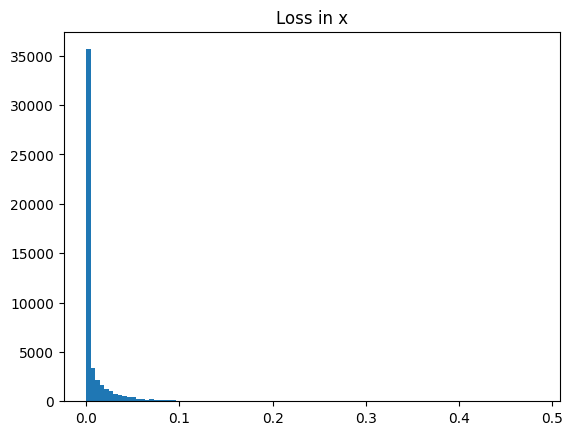

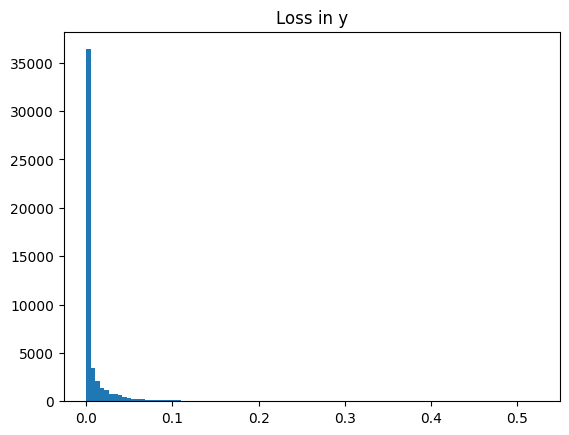

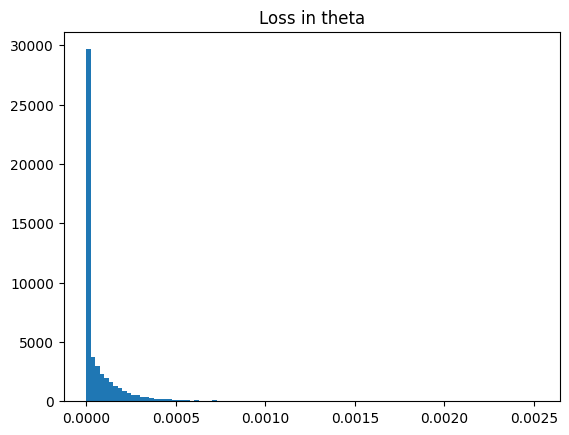

In [29]:
plt.hist(loss_x, bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y, bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta, bins=100)
plt.title('Loss in theta')
plt.show()

In [41]:
# identify outliers
outlier_threshold = 0.05

throttles = []
steers = []
speeds = []

# plot outliers
for i, (lx, ly, lt) in enumerate(zip(loss_x, loss_y, loss_theta)):
    if lx > outlier_threshold or ly > outlier_threshold or lt > outlier_threshold:
        print(s0_batch[i].velocity, a_batch[i])
        print(lx, ly, lt)
        throttles.append(a_batch[i][0])
        steers.append(a_batch[i][1])
        speeds.append(np.linalg.norm(s0_batch[i].velocity))

[11.18659183 14.80145313] (-0.9846819567400535, 0.4321151556679814)
0.05828536 0.032783702 0.00029144983
[-11.67057841  -0.03213699] (-0.11785478933012206, 0.7896973581025497)
0.0073691993 0.0635839 5.7510322e-05
[-0.6257799  12.38650077] (-0.13312464756289244, -0.008244579817489495)
0.05666642 0.003639756 5.957797e-05
[-10.59597036  -7.02981459] (0.30258347573138145, 0.2851428592504106)
0.00080918614 0.08943024 0.00027140538
[-10.75267622  32.45599109] (0.7848667779359522, -0.7477614147928922)
0.00020463631 0.13550405 2.929485e-05
[-29.32335223 -19.98941689] (-0.1063490762392576, -0.6891107014676323)
0.0044493964 0.13216874 4.802284e-05
[8.91008436 3.62838277] (0.1582270111782038, -0.6587551830606018)
0.05405318 0.013902746 6.507686e-05
[-0.57156706 19.53684388] (0.006006612309700676, -0.22128947449685032)
0.07516663 0.02688397 0.00017303074
[  5.01128376 -36.46051193] (-0.08252843618390693, 0.03144617726975163)
0.08117138 0.007400342 3.6895756e-06
[-23.8679629   -0.31952583] (-0.0545

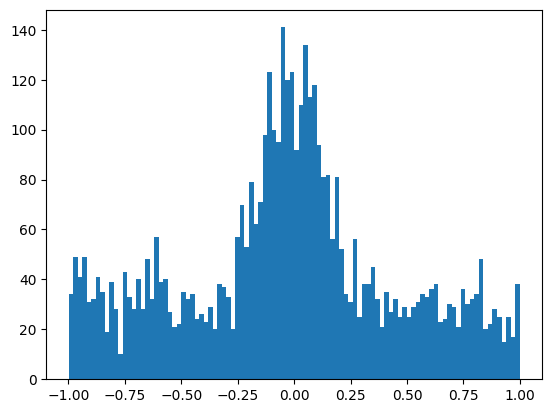

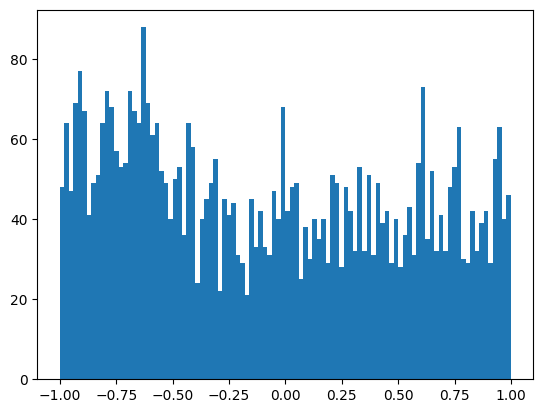

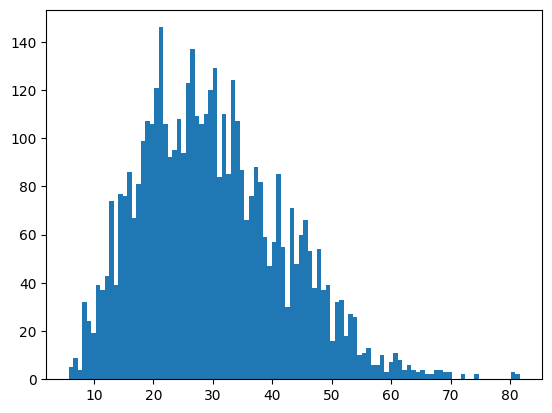

In [42]:
plt.hist(throttles, bins=100)
plt.show()
plt.hist(steers, bins=100)
plt.show()
plt.hist(speeds, bins=100)
plt.show()

In [39]:
throttles_normal = [a[0] for a in a_batch]
steers_normal = [a[1] for a in a_batch]

(array([  241.,   289.,   257.,   279.,   281.,   195.,   270.,   261.,
          255.,   236.,   245.,   216.,   237.,   254.,   199.,   247.,
          267.,   284.,   234.,   286.,   230.,   261.,   219.,   255.,
          247.,   285.,   258.,   251.,   226.,   213.,   221.,   297.,
          248.,   256.,   312.,   237.,   226.,   241.,   274.,   243.,
          246.,   253.,   239.,   257.,   294.,   278.,   245.,   291.,
          823., 12436., 12067.,   771.,   310.,   234.,   244.,   214.,
          253.,   233.,   252.,   306.,   231.,   265.,   245.,   271.,
          210.,   233.,   247.,   267.,   259.,   249.,   250.,   257.,
          254.,   223.,   227.,   263.,   237.,   240.,   278.,   191.,
          263.,   232.,   258.,   228.,   223.,   196.,   249.,   215.,
          238.,   250.,   295.,   256.,   240.,   238.,   237.,   241.,
          239.,   223.,   233.,   270.]),
 array([-9.99707103e-01, -9.79710757e-01, -9.59714411e-01, -9.39718065e-01,
        -9.1972171

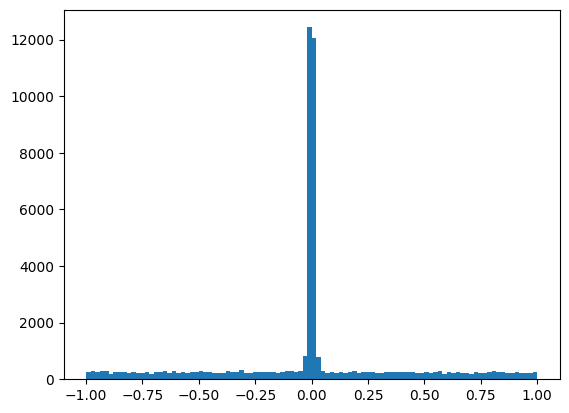

In [40]:
plt.hist(throttles_normal, bins=100)